In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.metrics import Recall, Precision, BinaryAccuracy
from tensorflow import keras

import sklearn

import os
import cv2

# Loading Data
data is split into two fire and no-fire folders, with equal number of images in each

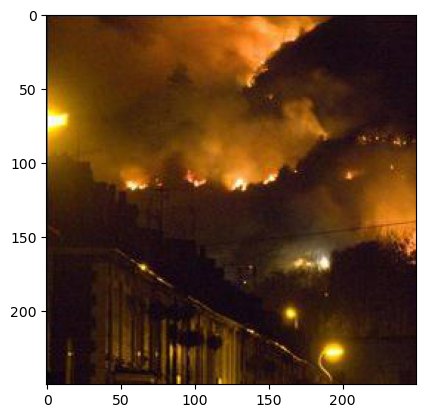

In [2]:
file_path_ex = os.path.join('Training_and_Validation', 'fire', 'fire_0001.jpg')
ex_img = cv2.imread(file_path_ex)
plt.imshow(cv2.cvtColor(ex_img, cv2.COLOR_BGR2RGB))
plt.show()

In [3]:
# batch size defaults to 32
data = tf.keras.utils.image_dataset_from_directory('Training_and_Validation', image_size=(250, 250))
test_data = tf.keras.utils.image_dataset_from_directory('Testing', image_size=(250, 250))

Found 1520 files belonging to 2 classes.
Found 380 files belonging to 2 classes.


In [4]:
print(str(len(data)) + " training and validation batches + " + str(len(test_data)) + " testing batches")

48 training and validation batches + 12 testing batches


In [5]:
data_iterator = data.as_numpy_iterator()
ex_batch = data_iterator.next()
ex_batch

2023-09-26 20:54:06.407644: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1520]
	 [[{{node Placeholder/_0}}]]
2023-09-26 20:54:06.407825: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1520]
	 [[{{node Placeholder/_0}}]]
2023-09-26 20:54:06.417401: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


(array([[[[131., 150., 148.],
          [116., 134., 134.],
          [105., 120., 123.],
          ...,
          [ 66.,  78.,  74.],
          [ 67.,  77.,  76.],
          [ 44.,  54.,  53.]],
 
         [[127., 145., 145.],
          [114., 132., 132.],
          [103., 118., 123.],
          ...,
          [ 74.,  86.,  84.],
          [ 67.,  77.,  76.],
          [ 42.,  52.,  51.]],
 
         [[116., 134., 136.],
          [106., 124., 128.],
          [ 99., 114., 119.],
          ...,
          [ 75.,  87.,  87.],
          [ 64.,  74.,  75.],
          [ 36.,  46.,  47.]],
 
         ...,
 
         [[146., 159., 150.],
          [142., 155., 145.],
          [ 68.,  80.,  66.],
          ...,
          [ 27.,  31.,  34.],
          [ 28.,  32.,  35.],
          [ 28.,  32.,  35.]],
 
         [[147., 162., 155.],
          [142., 155., 146.],
          [ 85.,  97.,  85.],
          ...,
          [ 27.,  32.,  35.],
          [ 28.,  33.,  36.],
          [ 28.,  33.,  36.

In [6]:
ex_batch[0].shape

(32, 250, 250, 3)

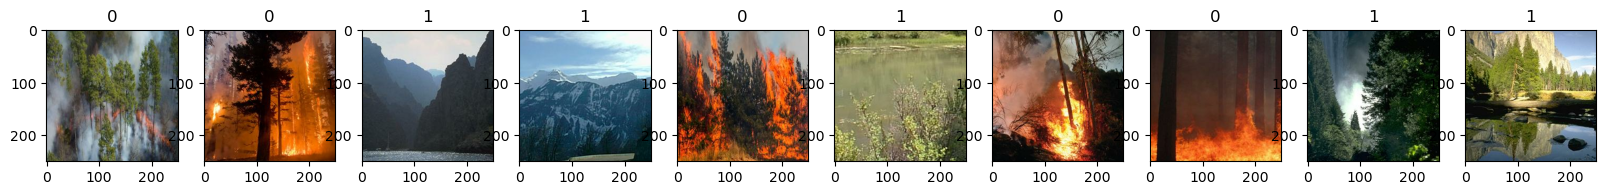

In [7]:
# check that the batches have been properly configured
fig, ax = plt.subplots(ncols = 10, figsize = (20, 20), nrows = 1)
for idx, img in enumerate(ex_batch[0][:10]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(ex_batch[1][idx])

1 is no-fire, 0 is fire

# Pre-processing

In [8]:
# preprocessing
# convert color scale to 0 - 1
data = data.map(lambda x, y: (x / 255.0 , y))
test_data = test_data.map(lambda x, y: (x / 255.0 , y))
data_iterator = data.as_numpy_iterator()
ex_batch = data_iterator.next()
ex_batch[0].max()
# checking that the max color is 1.0 instead of 255

2023-09-26 20:54:07.110921: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1520]
	 [[{{node Placeholder/_4}}]]
2023-09-26 20:54:07.111081: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1520]
	 [[{{node Placeholder/_4}}]]


1.0

splitting data:

In [9]:
# 90 - 10 split for the testing data
train_size = int(0.9 * len(data))
val_size = int(0.1 * len(data)) + 1
test_size = len(test_data)
print(str(len(data)) + " batches: split with " + str(train_size) + " for training and the other " + str(val_size) + " for validation")

48 batches: split with 43 for training and the other 5 for validation


In [10]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = test_data

#Building model

In [11]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape= (250, 250, 3)),
    MaxPooling2D(),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(),
    # remove color
    Flatten(), 
    Dense(250, activation='relu'),
    Dense(1, activation='sigmoid')
    # could consider changing to softmax activation
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 248, 248, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 124, 124, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 122, 122, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 61, 61, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 59, 59, 32)        9248      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 29, 29, 32)       0

In [12]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics = ['accuracy'])

Training

In [13]:
callback = tf.keras.callbacks.TensorBoard('logs')

In [14]:
hist = model.fit(train, epochs = 20, validation_data = val, callbacks = [callback])

Epoch 1/20


2023-09-26 20:54:07.314237: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1520]
	 [[{{node Placeholder/_0}}]]
2023-09-26 20:54:07.314432: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1520]
	 [[{{node Placeholder/_4}}]]


43/43 [==============================] - ETA: 0s - loss: 0.2514 - accuracy: 0.9099

2023-09-26 20:54:20.399650: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1520]
	 [[{{node Placeholder/_4}}]]
2023-09-26 20:54:20.399880: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1520]
	 [[{{node Placeholder/_4}}]]


43/43 [==============================] - 14s 309ms/step - loss: 0.2514 - accuracy: 0.9099 - val_loss: 0.1493 - val_accuracy: 0.9375
Epoch 2/20
43/43 [==============================] - 13s 304ms/step - loss: 0.1128 - accuracy: 0.9608 - val_loss: 0.0407 - val_accuracy: 0.9931
Epoch 3/20
43/43 [==============================] - 13s 297ms/step - loss: 0.1184 - accuracy: 0.9644 - val_loss: 0.1412 - val_accuracy: 0.9444
Epoch 4/20
43/43 [==============================] - 14s 321ms/step - loss: 0.1224 - accuracy: 0.9600 - val_loss: 0.0490 - val_accuracy: 0.9931
Epoch 5/20
43/43 [==============================] - 13s 298ms/step - loss: 0.0712 - accuracy: 0.9782 - val_loss: 0.0611 - val_accuracy: 0.9861
Epoch 6/20
43/43 [==============================] - 14s 314ms/step - loss: 0.0628 - accuracy: 0.9789 - val_loss: 0.0591 - val_accuracy: 0.9792
Epoch 7/20
43/43 [==============================] - 13s 305ms/step - loss: 0.0660 - accuracy: 0.9789 - val_loss: 0.0300 - val_accuracy: 0.9861
Epoch 8/20

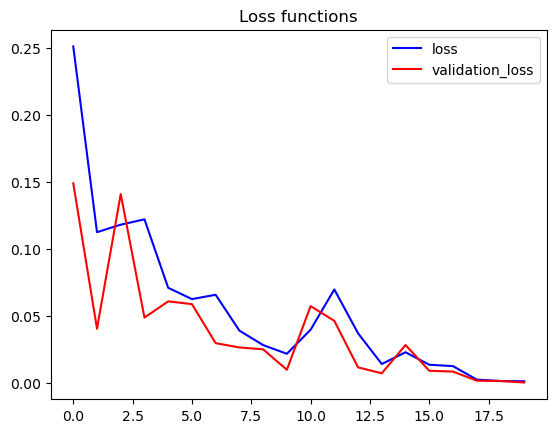

In [15]:
plt.plot(hist.history['loss'], label = 'loss', color='blue')
plt.plot(hist.history['val_loss'], label = 'validation_loss', color = 'red')
plt.title("Loss functions")
plt.legend()
plt.show()

Rerunning the model different times to combat overfitting

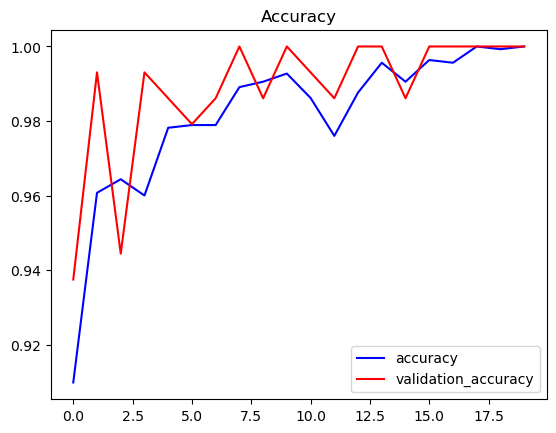

In [16]:
plt.plot(hist.history['accuracy'], label = 'accuracy', color='blue')
plt.plot(hist.history['val_accuracy'], label = 'validation_accuracy', color = 'red')
plt.title("Accuracy")
plt.legend()
plt.show()

Test performance

In [17]:
precision = Precision()
recall = Recall()
acc = BinaryAccuracy()

In [18]:
test_iterator = test_data.as_numpy_iterator()
for X, y in test_iterator:
    y_hat = model.predict(X)
    precision.update_state(y, y_hat)
    recall.update_state(y, y_hat)
    acc.update_state(y, y_hat)

2023-09-26 20:58:28.487996: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [380]
	 [[{{node Placeholder/_4}}]]
2023-09-26 20:58:28.488178: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [380]
	 [[{{node Placeholder/_4}}]]


1/1 [==============================] - 0s 104ms/step


In [19]:
precision.result().numpy()

0.9408602

In [20]:
recall.result().numpy()

0.92105263

In [21]:
acc.result().numpy()

0.93157893

Testing on specific cases

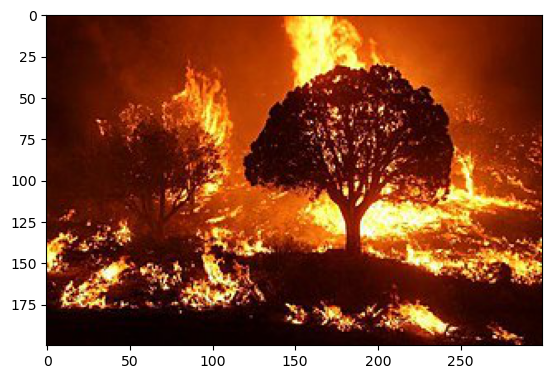

In [22]:
# now some code for any inputted image
fire_img = cv2.imread(os.path.join('examples', 'fire.jpg'))
plt.imshow(cv2.cvtColor(fire_img, cv2.COLOR_BGR2RGB))
plt.show()

In [23]:
# resizing to fit model input
fire_img = tf.image.resize(fire_img, (250, 250))
# cv2 reads images in BGR and not RGB so the following line changes that because the model was trained on RGB images
fire_img = fire_img[...,::-1]
# adds a dimension to fit how the model was trained
y_hat_fire = model.predict(np.expand_dims(fire_img / 255, 0))
y_hat_fire

1/1 [==============================] - 0s 15ms/step


array([[1.3734054e-07]], dtype=float32)

Since 0 is a fire classification, the model classifies it correctly

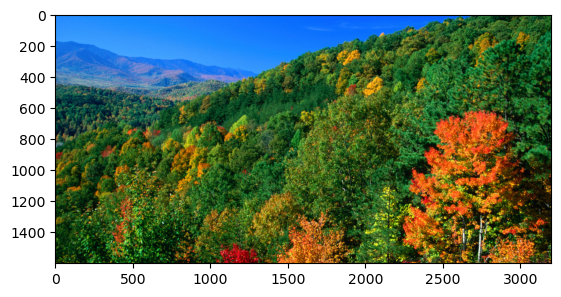

In [24]:
forest_img = cv2.imread(os.path.join('examples', 'forest.jpg' ))
plt.imshow(cv2.cvtColor(forest_img, cv2.COLOR_BGR2RGB))
plt.show()

In [25]:
# once again same steps for this forest image
forest_img = tf.image.resize(forest_img, (250, 250))
forest_img = forest_img[...,::-1]

y_hat_forest = model.predict(np.expand_dims(forest_img / 255, 0))
y_hat_forest

1/1 [==============================] - 0s 15ms/step


array([[1.]], dtype=float32)

Also correctly classifies this forest

In [26]:
lake_tahoe_img = cv2.imread(os.path.join('examples', 'lake_tahoe.jpeg' ))
lake_tahoe_img = tf.image.resize(lake_tahoe_img, (250, 250))
lake_tahoe_img = lake_tahoe_img[...,::-1]

y_hat_tahoe = model.predict(np.expand_dims(lake_tahoe_img / 255, 0))
y_hat_tahoe


1/1 [==============================] - 0s 17ms/step


array([[0.9928068]], dtype=float32)

In [27]:
model.save(os.path.join('models', 'fire_detection_model.h5'))

Load in model:

In [28]:
saved_model = load_model(os.path.join('models', 'fire_detection_model.h5'))
saved_model.predict(np.expand_dims(forest_img / 255, 0))
# predicts the forest image correctly as well

1/1 [==============================] - 0s 36ms/step


array([[1.]], dtype=float32)